# Quality Prediction in a Mining Process

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import probscale

pd.set_option("display.max_columns", None)

MAIN_COLOR = 'orange'

In [2]:
v = !python --version
print('Версия python: {}'.format(v))
print('Версия numpy: {}'.format(np.__version__))
print('Версия pandas: {}'.format(pd.__version__))
print('Версия matplotlib: {}'.format(matplotlib.__version__))
print('Версия seaborn: {}'.format(sns.__version__))

Версия python: ['Python 3.9.12']
Версия numpy: 1.21.5
Версия pandas: 1.4.2
Версия matplotlib: 3.5.1
Версия seaborn: 0.11.2


## Read data

In [3]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv('MiningProcess_Flotation_Plant_Database.csv', parse_dates={'datetime': ['date']}, date_parser=dateparse, decimal=',')

## EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   datetime                      737453 non-null  datetime64[ns]
 1   % Iron Feed                   737453 non-null  float64       
 2   % Silica Feed                 737453 non-null  float64       
 3   Starch Flow                   737453 non-null  float64       
 4   Amina Flow                    737453 non-null  float64       
 5   Ore Pulp Flow                 737453 non-null  float64       
 6   Ore Pulp pH                   737453 non-null  float64       
 7   Ore Pulp Density              737453 non-null  float64       
 8   Flotation Column 01 Air Flow  737453 non-null  float64       
 9   Flotation Column 02 Air Flow  737453 non-null  float64       
 10  Flotation Column 03 Air Flow  737453 non-null  float64       
 11  Flotation Col

#### Mising data

In [5]:
df[df.isna().any(axis=1)]

Empty DataFrame
Columns: [datetime, % Iron Feed, % Silica Feed, Starch Flow, Amina Flow, Ore Pulp Flow, Ore Pulp pH, Ore Pulp Density, Flotation Column 01 Air Flow, Flotation Column 02 Air Flow, Flotation Column 03 Air Flow, Flotation Column 04 Air Flow, Flotation Column 05 Air Flow, Flotation Column 06 Air Flow, Flotation Column 07 Air Flow, Flotation Column 01 Level, Flotation Column 02 Level, Flotation Column 03 Level, Flotation Column 04 Level, Flotation Column 05 Level, Flotation Column 06 Level, Flotation Column 07 Level, % Iron Concentrate, % Silica Concentrate]
Index: []

#### Preprocessing of data
'% Iron Concentrate' should be deleted from data becasue it measures in lab after flotation and can't be part of features

In [19]:
df.columns = [clm.replace(' ', '_').lower() for clm in df.columns]

NUM_FEATURES = [ # Do not use '% Iron Concentrate' because of highly correlated (0.8) with target and do not use datetime
    '%_iron_feed','%_silica_feed', 'starch_flow', 'amina_flow',
    'ore_pulp_flow', 'ore_pulp_ph', 'ore_pulp_density',
    'flotation_column_01_air_flow', 'flotation_column_02_air_flow', 'flotation_column_03_air_flow',
    'flotation_column_04_air_flow', 'flotation_column_05_air_flow', 'flotation_column_06_air_flow',
    'flotation_column_07_air_flow', 'flotation_column_01_level', 'flotation_column_02_level',
    'flotation_column_03_level', 'flotation_column_04_level', 'flotation_column_05_level',
    'flotation_column_06_level', 'flotation_column_07_level',
]
TARGET = '%_silica_concentrate'

create_feature_dict = {
    '%_iron_feed': ['last'],
    '%_silica_feed': ['last'],
    **{clm: [np.mean, np.max, np.min] for clm in df.columns}
}

df_feature = df.groupby(pd.Grouper(key='datetime', axis=0, freq='H')).agg(create_feature_dict).reset_index()

df_feature.columns = ['_'.join(col) for col in df_feature.columns]
df_feature

datetime_  %_iron_feed_mean  %_iron_feed_amax  \
0    2017-03-10 01:00:00             55.20             55.20   
1    2017-03-10 02:00:00             55.20             55.20   
2    2017-03-10 03:00:00             55.20             55.20   
3    2017-03-10 04:00:00             55.20             55.20   
4    2017-03-10 05:00:00             55.20             55.20   
...                  ...               ...               ...   
4410 2017-09-09 19:00:00             49.75             49.75   
4411 2017-09-09 20:00:00             49.75             49.75   
4412 2017-09-09 21:00:00             49.75             49.75   
4413 2017-09-09 22:00:00             49.75             49.75   
4414 2017-09-09 23:00:00             49.75             49.75   

      %_iron_feed_amin  %_silica_feed_mean  %_silica_feed_amax  \
0                55.20               16.98               16.98   
1                55.20               16.98               16.98   
2                55.20               16.98               16.98   
3                55.20               16.98               16.98   
4                55.20               16.98               16.98   
...                ...                 ...                 ...   
4410             49.75               23.20               23.20   
4411             49.75               23.20               23.20   
4412             49.75               23.20               23.20   
4413             49.75               23.20               23.20   
4414             49.75               23.20               23.20   

      %_silica_feed_amin       datetime_mean       datetime_amax  \
0                  16.98 2017-03-10 01:00:00 2017-03-10 01:00:00   
1                  16.98 2017-03-10 02:00:00 2017-03-10 02:00:00   
2                  16.98 2017-03-10 03:00:00 2017-03-10 03:00:00   
3                  16.98 2017-03-10 04:00:00 2017-03-10 04:00:00   
4                  16.98 2017-03-10 05:00:00 2017-03-10 05:00:00   
...                  ...                 ...                 ...   
4410               23.20 2017-09-09 19:00:00 2017-09-09 19:00:00   
4411               23.20 2017-09-09 20:00:00 2017-09-09 20:00:00   
4412               23.20 2017-09-09 21:00:00 2017-09-09 21:00:00   
4413               23.20 2017-09-09 22:00:00 2017-09-09 22:00:00   
4414               23.20 2017-09-09 23:00:00 2017-09-09 23:00:00   

           datetime_amin  starch_flow_mean  starch_flow_amax  \
0    2017-03-10 01:00:00       3162.625026           3907.42   
1    2017-03-10 02:00:00       3133.256389           4016.60   
2    2017-03-10 03:00:00       3479.482944           4049.80   
3    2017-03-10 04:00:00       3228.036436           3699.22   
4    2017-03-10 05:00:00       3327.280739           3887.11   
...                  ...               ...               ...   
4410 2017-09-09 19:00:00       3327.047776           4517.39   
4411 2017-09-09 20:00:00       4225.800333           4703.13   
4412 2017-09-09 21:00:00       2808.214692           3529.49   
4413 2017-09-09 22:00:00       3191.497672           4245.08   
4414 2017-09-09 23:00:00       3638.543653           5068.55   

      starch_flow_amin  amina_flow_mean  amina_flow_amax  amina_flow_amin  \
0             367.3830       578.786678          610.748          540.039   
1            1402.3400       537.219661          572.357          492.859   
2            3197.6600       591.906744          611.572          569.336   
3              52.7344       593.170106          624.390          561.768   
4             195.8980       619.710806          646.667          594.360   
...                ...              ...              ...              ...   
4410           30.7356       497.211189          521.947          469.186   
4411         3208.9800       508.963856          566.305          479.400   
4412          355.9560       517.748822          552.149          501.615   
4413          545.8970       492.511228          522.620          432.817   
4414           76.68

In [6]:
NUM_FEATURES = [
       '% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate'
]
TARGET = '% Silica Concentrate'

In [7]:
df[NUM_FEATURES] = df[NUM_FEATURES].apply(pd.to_numeric, errors='coerce')

In [8]:
df.head(3)

datetime  % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  \
0 2017-03-10 01:00:00         55.2          16.98      3019.53     557.434   
1 2017-03-10 01:00:00         55.2          16.98      3024.41     563.965   
2 2017-03-10 01:00:00         55.2          16.98      3043.46     568.054   

   Ore Pulp Flow  Ore Pulp pH  Ore Pulp Density  Flotation Column 01 Air Flow  \
0        395.713      10.0664              1.74                       249.214   
1        397.383      10.0672              1.74                       249.719   
2        399.668      10.0680              1.74                       249.741   

   Flotation Column 02 Air Flow  Flotation Column 03 Air Flow  \
0                       253.235                       250.576   
1                       250.532                       250.862   
2                       247.874                       250.313   

   Flotation Column 04 Air Flow  Flotation Column 05 Air Flow  \
0                       295.096                         306.4   
1                       295.096                         306.4   
2                       295.096                         306.4   

   Flotation Column 06 Air Flow  Flotation Column 07 Air Flow  \
0                       250.225                       250.884   
1                       250.137                       248.994   
2                       251.345                       248.071   

   Flotation Column 01 Level  Flotation Column 02 Level  \
0                    457.396                    432.962   
1                    451.891                    429.560   
2                    451.240                    468.927   

   Flotation Column 03 Level  Flotation Column 04 Level  \
0                    424.954                    443.558   
1                    432.939                    448.086   
2                    434.610                    449.688   

   Flotation Column 05 Level  Flotation Column 06 Level  \
0                    502.255                    446.370   
1                    496.363                    445.922   
2                    484.411                    447.826   

   Flotation Column 07 Level  % Iron Concentrate  % Silica Concentrate  
0                    523.344               66.91                  1.31  
1                    498.075               66.91                  1.31  
2                    458.567               66.91                  1.31

In [9]:
df[NUM_FEATURES].describe().T

% Iron Feed  % Silica Feed    Starch Flow     Amina Flow  \
count  737453.000000  737453.000000  737453.000000  737453.000000   
mean       56.294739      14.651716    2869.140569     488.144697   
std         5.157744       6.807439    1215.203734      91.230534   
min        42.740000       1.310000       0.002026     241.669000   
25%        52.670000       8.940000    2076.320000     431.796000   
50%        56.080000      13.850000    3018.430000     504.393000   
75%        59.720000      19.600000    3727.730000     553.257000   
max        65.780000      33.400000    6300.230000     739.538000   

       Ore Pulp Flow    Ore Pulp pH  Ore Pulp Density  \
count  737453.000000  737453.000000     737453.000000   
mean      397.578372       9.767639          1.680380   
std         9.699785       0.387007          0.069249   
min       376.249000       8.753340          1.519820   
25%       394.264000       9.527360          1.647310   
50%       399.249000       9.798100          1.697600   
75%       402.968000      10.038000          1.728330   
max       418.641000      10.808100          1.853250   

       Flotation Column 01 Air Flow  Flotation Column 02 Air Flow  \
count                 737453.000000                 737453.000000   
mean                     280.151856                    277.159965   
std                       29.621288                     30.149357   
min                      175.510000                    175.156000   
25%                      250.281000                    250.457000   
50%                      299.344000                    296.223000   
75%                      300.149000                    300.690000   
max                      373.871000                    375.992000   

       Flotation Column 03 Air Flow  Flotation Column 04 Air Flow  \
count                 737453.000000                 737453.000000   
mean                     281.082397                    299.447794   
std                       28.558268                      2.572538   
min                      176.469000                    292.195000   
25%                      250.855000                    298.262566   
50%                      298.696000                    299.805000   
75%                      300.382000                    300.638000   
max                      364.346000                    305.871000   

       Flotation Column 05 Air Flow  Flotation Column 06 Air Flow  \
count                 737453.000000                 737453.000000   
mean                     299.917814                    292.071485   
std                        3.636579                     30.217804   
min                      286.295000                    189.928000   
25%                      298.068000                    262.541000   
50%                      299.887120                    299.477000   
75%                      301.791137                    303.061000   
max                      310.270000                    370.910000   

       Flotation Column 07 Air Flow  Flotation Column 01 Level  \
count                 737453.000000              737453.000000   
mean                     290.754856                 520.244823   
std                       28.670105                 131.014924   
min                      185.962000                 149.218000   
25%                      256.302000                 416.978000   
50%                      299.011000                 491.878000   
75%                      301.904000                 594.114000   
max                      371.593000                 862.274000   

       Flotation Column 02 Level  Flotation Column 03 Level  \
count              737453.000000              737453.000000   
mean                  522.649555                 531.352662   
std                   128.165050                 150.842164   
min                   210.752000                 126.255000   
25%                   441.883000                 411.325000   
50%                   495.956000  

In [10]:
df[TARGET].describe()

count    737453.000000
mean          2.326763
std           1.125554
min           0.600000
25%           1.440000
50%           2.000000
75%           3.010000
max           5.530000
Name: % Silica Concentrate, dtype: float64

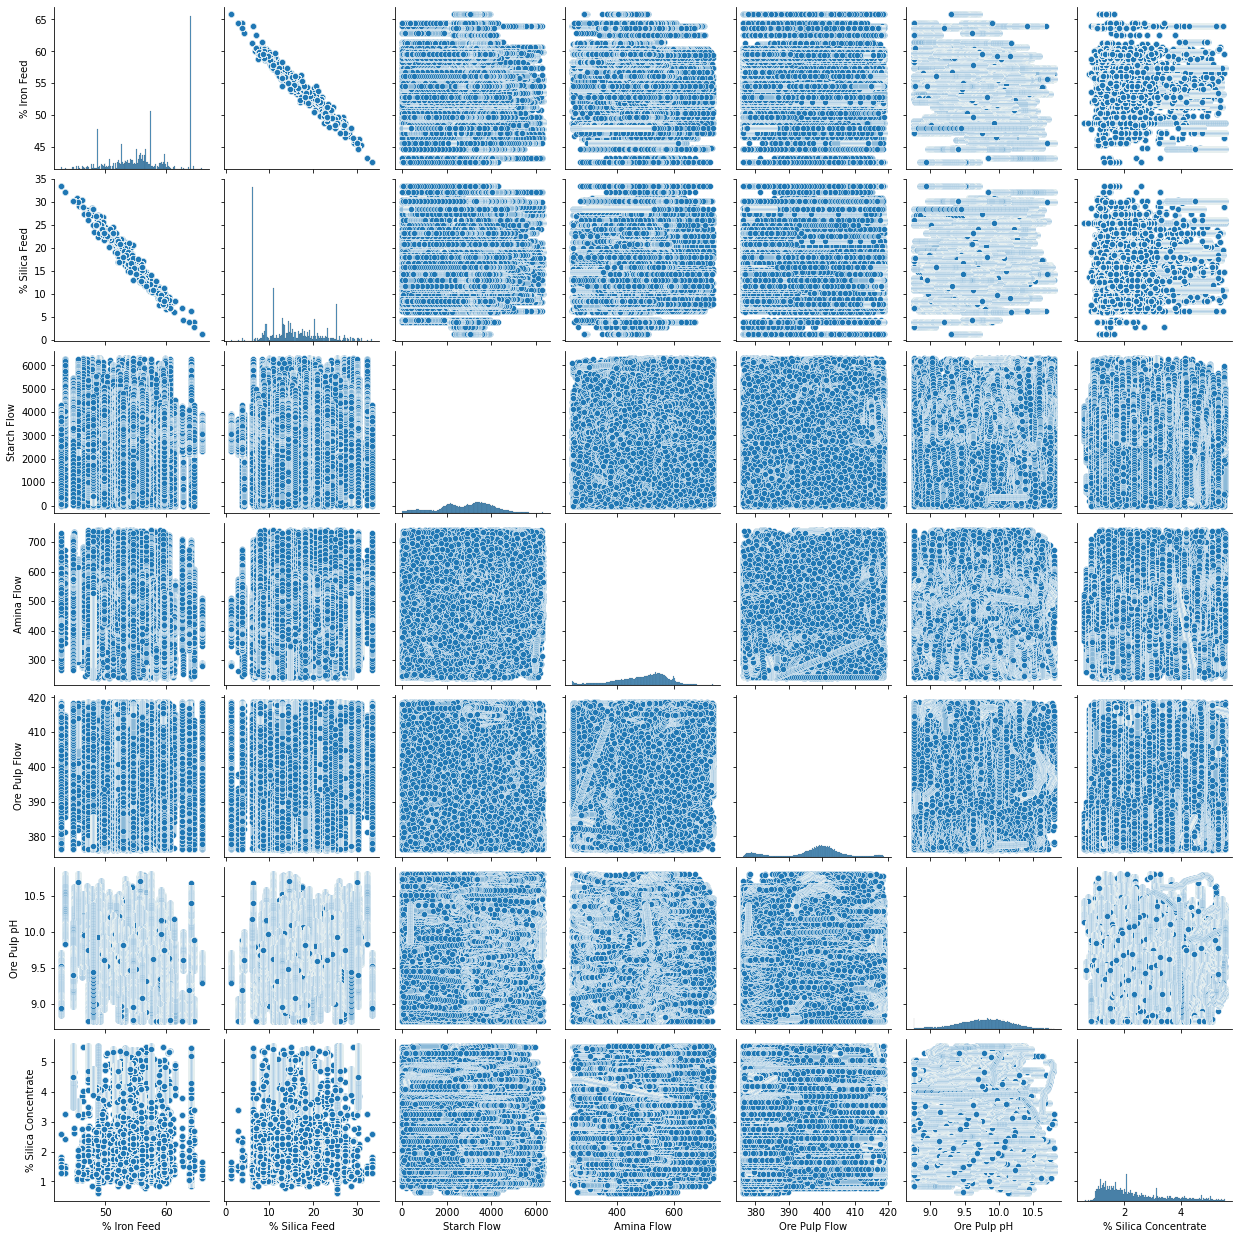

In [11]:
sns.pairplot(df[[
    *NUM_FEATURES[:6],
    TARGET
]])

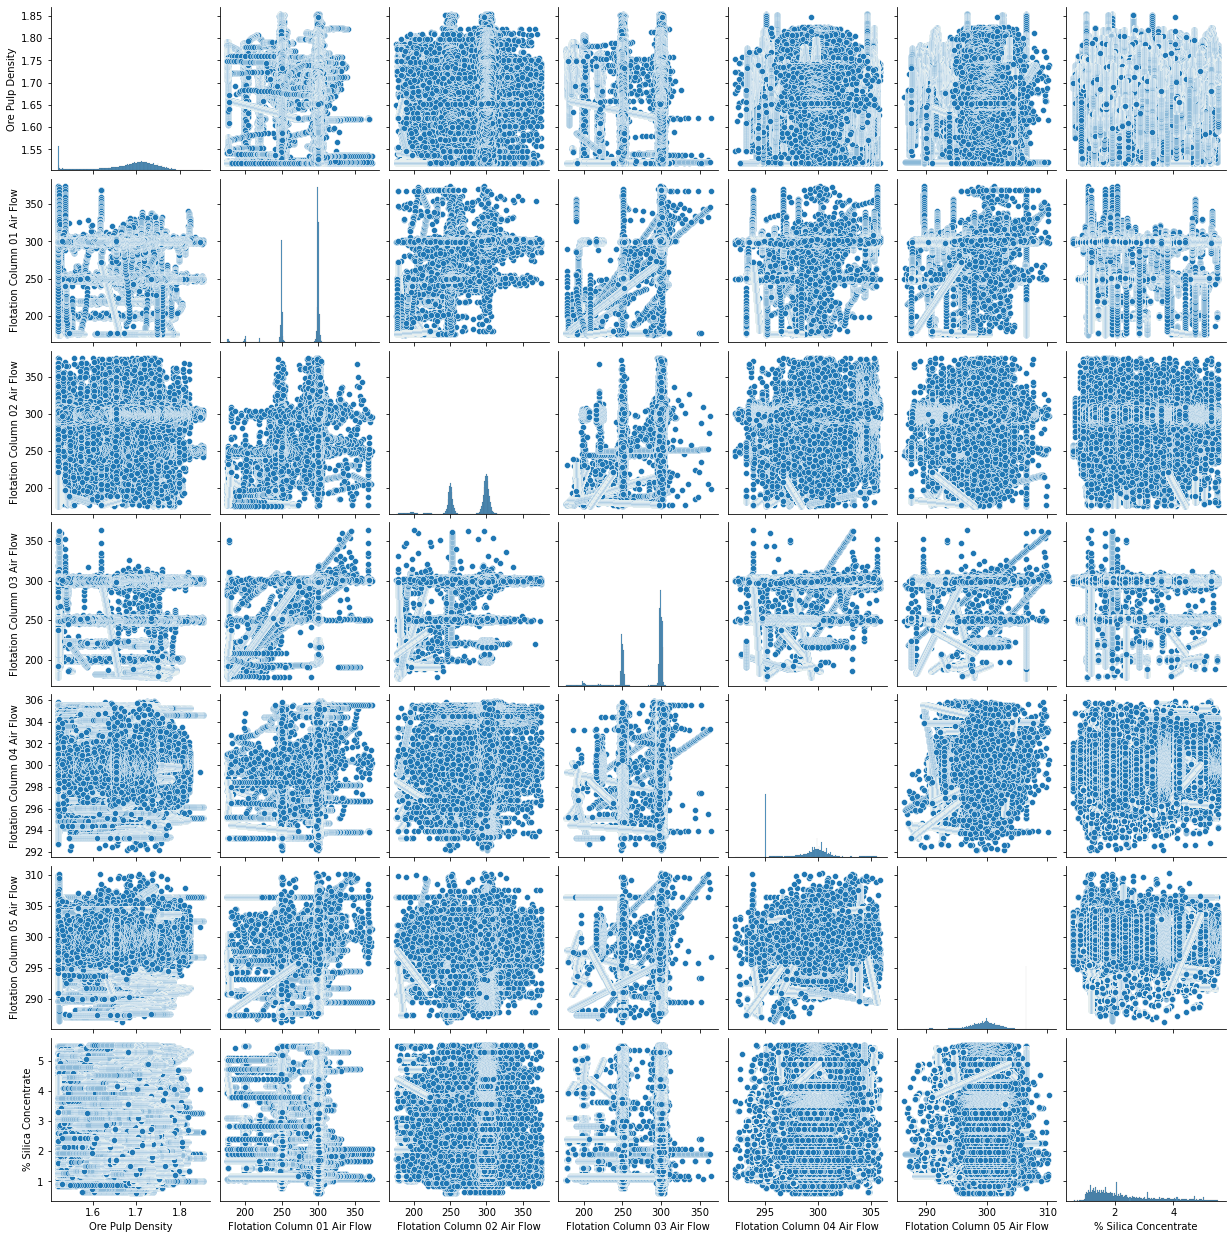

In [12]:
sns.pairplot(df[[
    *NUM_FEATURES[6:12],
    TARGET
]])

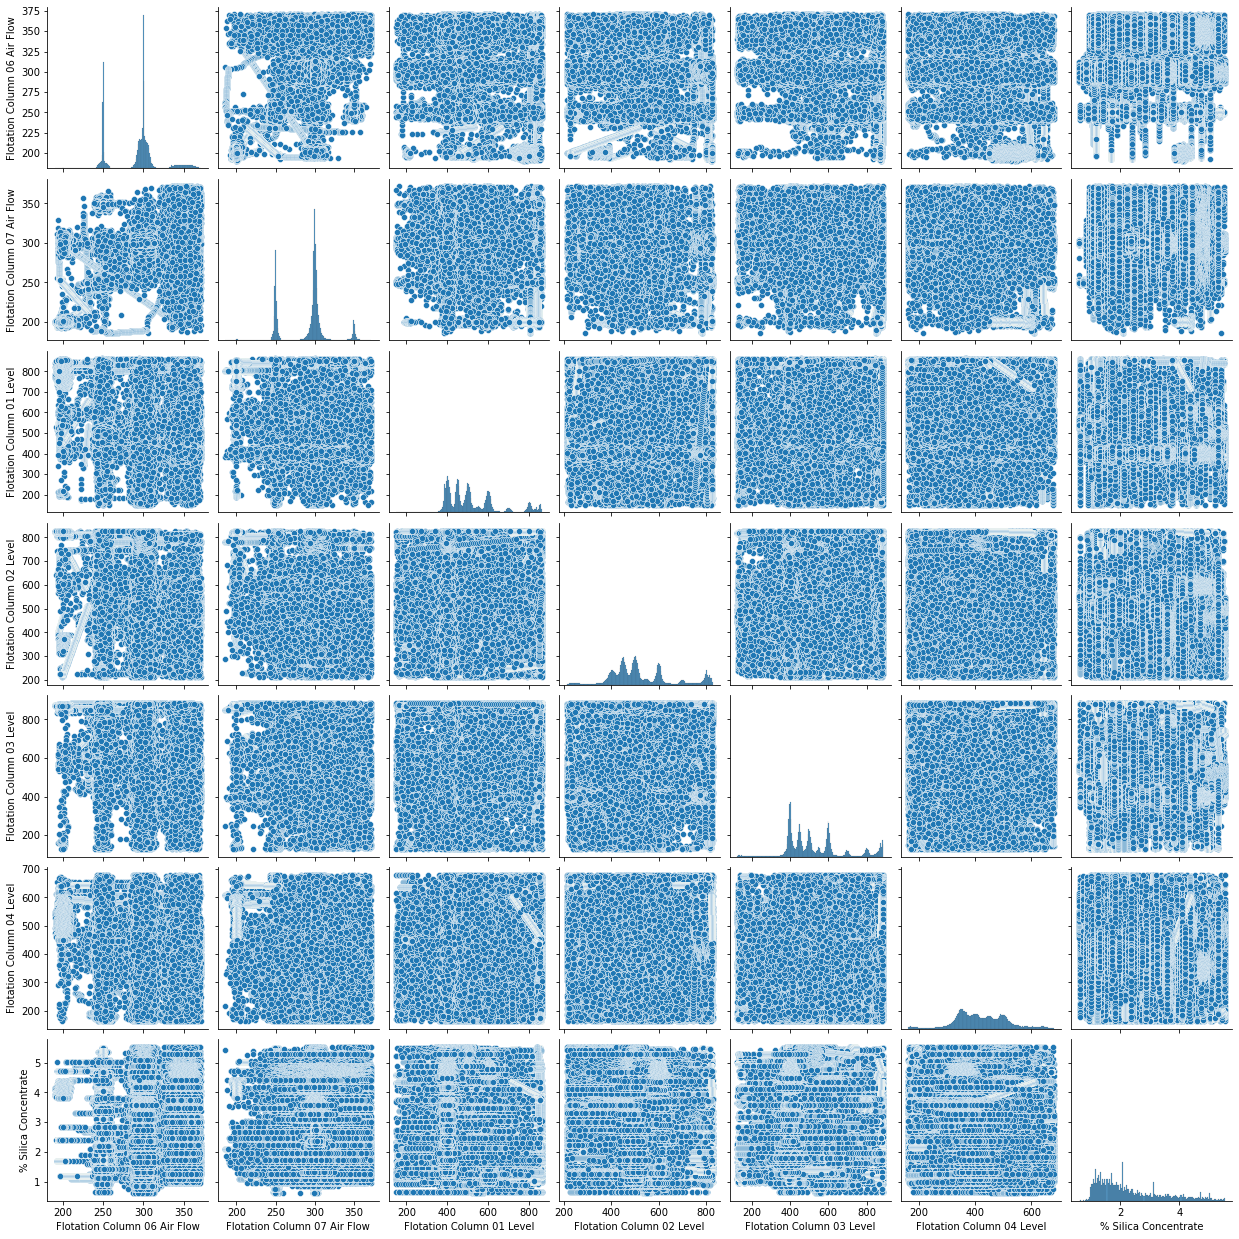

In [13]:
sns.pairplot(df[[
    *NUM_FEATURES[12:18],
    TARGET
]])

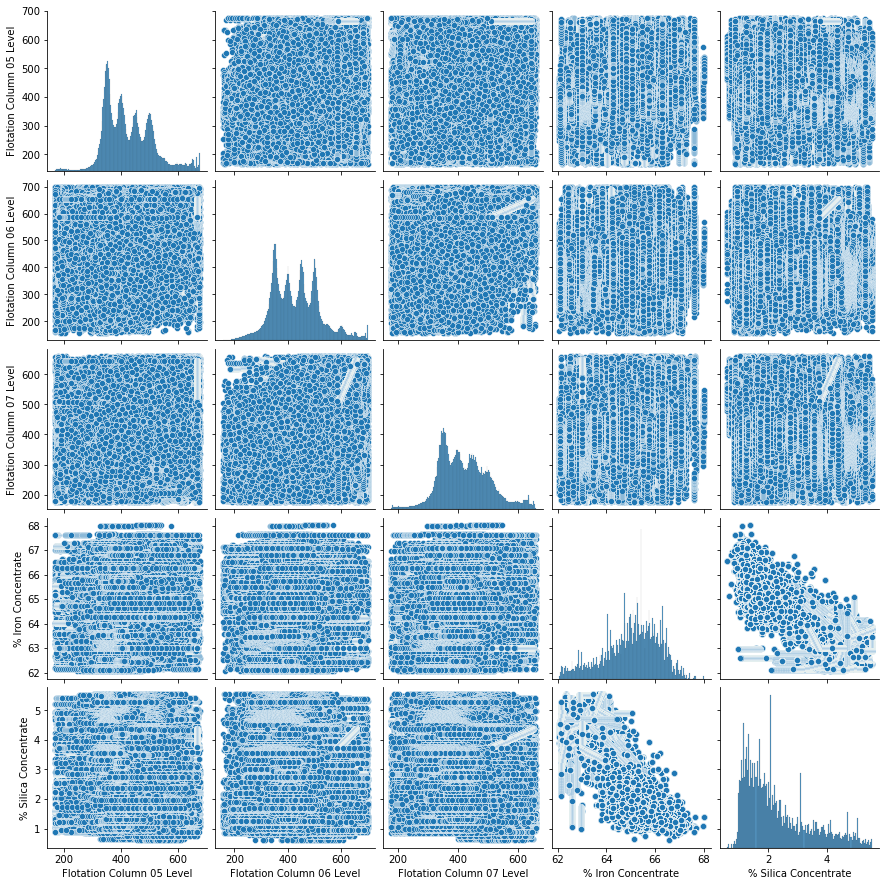

In [14]:
sns.pairplot(df[[
    *NUM_FEATURES[18:],
    TARGET
]])

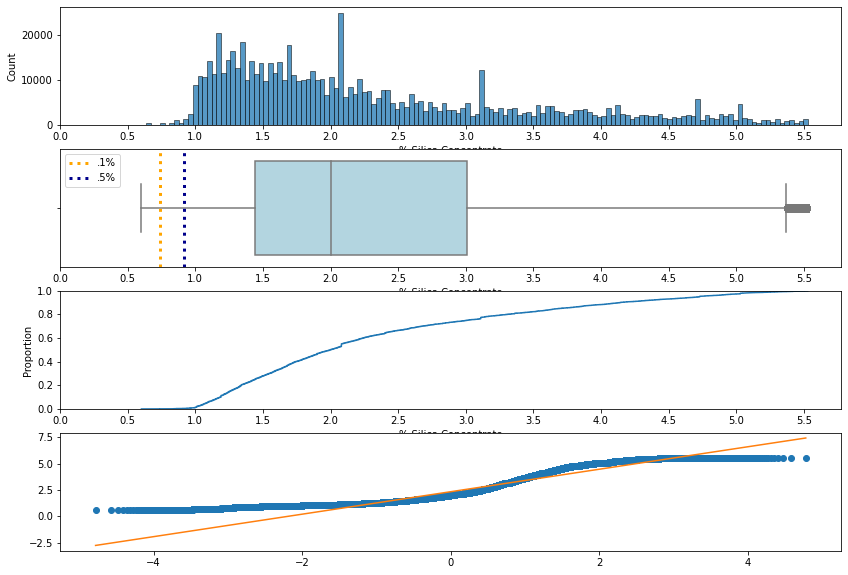

In [33]:
f,ax=plt.subplots(4, 1, figsize=(14,10))
#plt.title('Target values', fontsize=16)
sns.histplot(df[TARGET], ax=ax[0])
sns.boxplot(x=df[TARGET], color='lightblue', saturation=0.8, ax=ax[1])
ax[1].axvline(np.percentile(df[TARGET],.1), label='.1%', c='orange', linestyle=':', linewidth=3)
ax[1].axvline(np.percentile(df[TARGET],.5), label='.5%', c='darkblue', linestyle=':', linewidth=3)
ax[1].legend()
sns.ecdfplot(df[TARGET], ax=ax[2])
ax[0].set_xticks(np.arange(0, df[TARGET].max(), .5))
ax[1].set_xticks(np.arange(0, df[TARGET].max(), .5))
ax[2].set_xticks(np.arange(0, df[TARGET].max(), .5))
fig = probscale.probplot(
    df[TARGET],
    ax=ax[3],
    plottype='qq',
    bestfit=True
)
plt.show()
plt.show()

In [16]:
print(f"Skew of target {df[TARGET].skew():.3f}")

Skew of target 0.971


In [23]:
def myround(x, prec=2, base=.05):
    ''' Round value to given base '''
    return round(base * round(float(x)/base),prec)


def plot_dist(data, title='', xlabel='', ylabel='', binstep=0.05, figsize=(14,8), legend='right'):
    ''' Plot histogram and boxplot '''

    _, (ax1, ax2) = plt.subplots(
        nrows=2, ncols=1,
        figsize=figsize
    )

    xticks_range = np.arange(myround(data.min(), base=binstep), myround(data.max(), base=binstep) + binstep, binstep)

    #ax1.hist(data, bins=np.arange(data.min(), data.max())-0.5, color='darkviolet', edgecolor='black')
    sns.histplot(data, bins=xticks_range - 0.5*binstep, color = MAIN_COLOR, ax = ax1)
    #ax2.boxplot(data.values, vert=False)
    sns.boxplot(x=data, color = MAIN_COLOR, ax = ax2)

    ax1.axvline(x=data.mean(), color='r', linestyle='-', label = 'Cреднее = {:.2f}'.format(data.mean()))
    ax1.axvline(x=data.median(), color='darkviolet', linestyle='-', label = 'Медиана = {:.2f}'.format(data.median()))

    q1, q3 = np.percentile(data.dropna(), [25 ,75])
    iqr = q3 - q1
    loval = q1 - 1.5 * iqr
    hival = q3 + 1.5 * iqr
    wiskhi = np.compress(data.values <= hival, data.values)
    wisklo = np.compress(data.values >= loval, data.values)
    actual_hival = np.max(wiskhi)
    actual_loval = np.min(wisklo)

    ax1.axvline(x=q1, color='cyan', linestyle='-', label = '25% = {:.2f}'.format(q1))
    ax1.axvline(x=q3, color='b', linestyle='-', label = '75% = {:.2f}'.format(q3))
    ax1.axvline(x=actual_loval, color='hotpink', linestyle='-', label = 'Q1 - IQR*1.5 = {:.2f}'.format(actual_loval))
    ax1.axvline(x=actual_hival, color='darkorange', linestyle='-', label = 'Q3 + IQR*1.5 = {:.2f}'.format(actual_hival))
    ax1.legend(loc=f'upper {legend}', fontsize=12)

    ax1.set_xticks(xticks_range)
    ax1.set_title(title, fontsize = 20)
    ax1.set_xlabel(xlabel, fontsize = 14)
    ax1.set_ylabel(ylabel, fontsize = 14)
    ax1.grid(axis='y')

    ax2.set_xlim(ax1.get_xlim())    # sync 'x' axis of axes
    ax2.set_xlabel(xlabel, fontsize = 14)
    ax2.set_xticks(xticks_range)
    ax2.grid()

    plt.show()


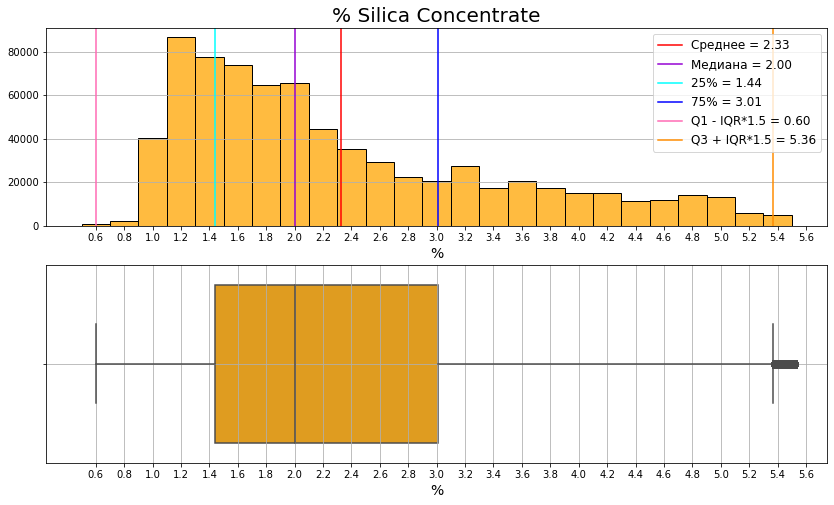

In [27]:
plot_dist(df[TARGET],
    title=f"{TARGET}",
    xlabel='%', ylabel="",
    binstep=0.2)

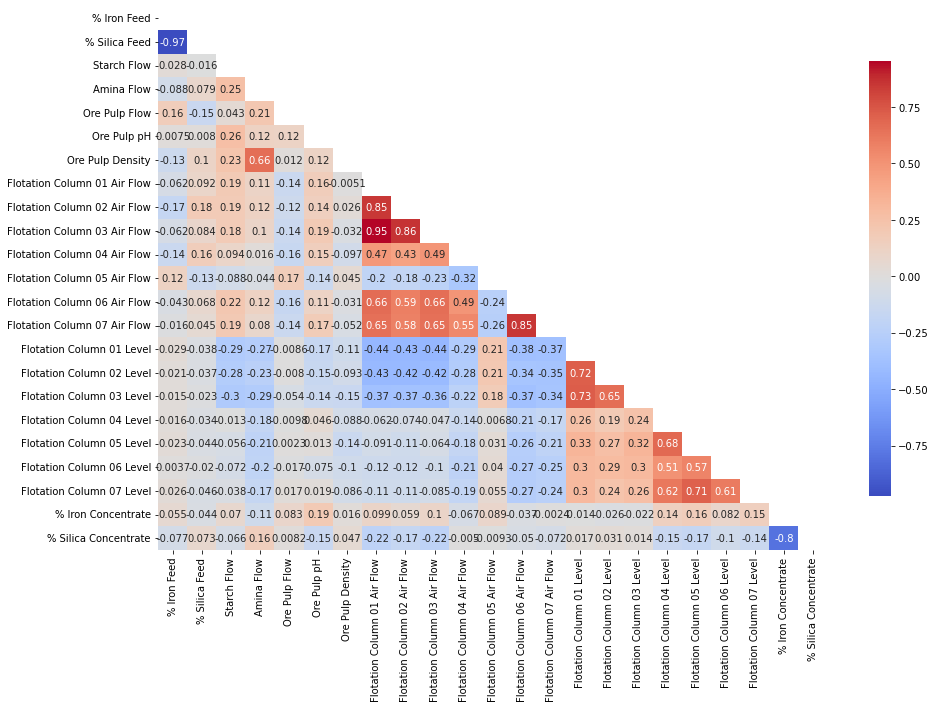

In [29]:
corrMatrix = df.corr(method='pearson', min_periods=1)
plt.figure(figsize=(15,10))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
ax = sns.heatmap(corrMatrix, annot=True, mask=mask, cbar_kws={"shrink": .8}, cmap='coolwarm')
plt.show()

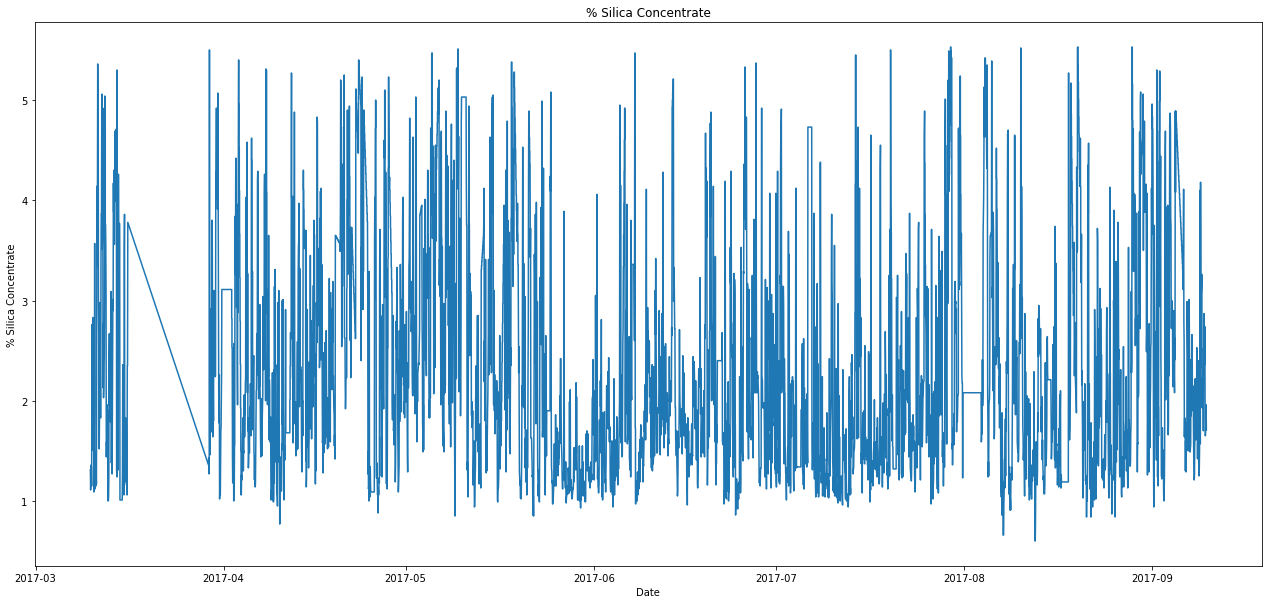

In [36]:
plt.figure(figsize=(22,10))
plt.plot(df.datetime, df[TARGET])
plt.title(f"{TARGET}")
plt.xlabel("Date")
plt.ylabel(f"{TARGET}")
plt.show()

#### Target

In [43]:
df[TARGET].groupby(df.datetime.dt.to_period('M')).agg(['mean', 'median', 'min', 'max'])

mean  median   min   max
datetime                              
2017-03   2.513733   2.240  1.00  5.50
2017-04   2.635433   2.460  0.77  5.40
2017-05   2.494664   2.090  0.85  5.51
2017-06   2.048125   1.820  0.86  5.47
2017-07   2.054832   1.660  0.94  5.53
2017-08   2.245712   2.040  0.60  5.53
2017-09   2.683287   2.455  0.94  5.30

In [51]:
df[TARGET].groupby(df.datetime.dt.weekday).agg(['mean', 'median', 'min', 'max'])

mean  median   min   max
datetime                              
0         2.321812    2.01  0.66  5.53
1         2.274606    2.02  0.85  5.51
2         2.364641    2.06  0.88  5.50
3         2.261412    1.93  0.97  5.52
4         2.377862    1.97  0.84  5.47
5         2.406886    2.07  0.60  5.53
6         2.274639    1.90  0.86  5.42